# Simple linear regression

In this discussion section, we will discuss **simple linear regression**.
That is, we have a single covariate $x$, and we want to model a linear relationship
with a target variable $y$.
For example, we might want to find a relationship between weight and height of horses.

Keep in mind that, as in the first lectures, this analysis is all algebra,
we do not impose any distributional assumptions; there is no probability theory involved.
Of course, later we will learn how imposing such structure and by using probability theory,
can lead to powerful statements that are currently beyond our reach.
However, it is also exciting that we can already do so many without any (restricting) assumptions!

## Contents

- Big picture
- Visualization
- Comparison with PCA
- Relation with correlation coefficient
- Residuals
- Binary covariate
- Two binary covariates
- A hidden covariate

## Big picture

**Define relationships in data**

- What do we see?
- Can we summarize the data?

Here, modeling is about **compression**:
We have many data points, and we have trouble grasping or handling this much data,
it leads to cognitive overload.
How can we summarize the structure of the data, 
which means finding a balance between a small summary while still capturing the relationships.

Compare this with summarizing a news article. 
Trimming it to a single word leads to dramatic loss of information,
and the most complete summary of the article is the article itself.
Note also that your objective drives how much to trim.
    
**Next steps**

- Can we predict what will happen? (*prediction*)
- What conclusions can we draw with how much certainty? (*inference*)
- Can we explain what we see? (*causality*)

## Setup and generating an artificial data set

We load some libraries and create some artificial data

In [1]:
library(ggplot2)
library(dplyr)
library(modelr)
library(knitr)
library(tibble)
library(repr)

options(repr.plot.width=4, repr.plot.height=3)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



weight,0.3360831,1.615033,0.7698847,0.6554686,1.204201,1.208788
height,0.7593430,2.291331,1.4384686,2.2358553,2.958348,2.505526


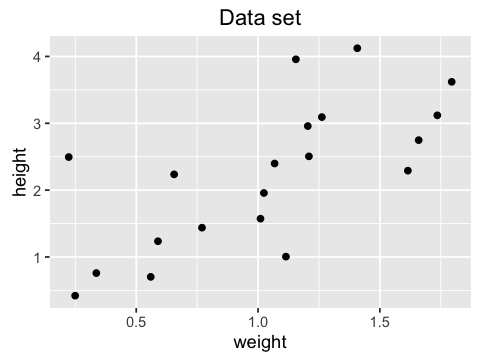

In [2]:
set.seed(3)

sigma <- 1
n <- 20
x <- runif(n, 0, 2)
y <- 1 + 1.5 * x + sigma * rnorm(n)


df <- tibble(weight = x,
       height = y)

df %>% 
  ggplot(aes(x=weight, y=height)) + 
  geom_point() +
  labs(title="Data set")

t(head(df))

## Defining "good"  in a "good model"

Define a relationship $Y \approx f(X)$ between X and Y, or weight and height in this example.

Note here that we make a subtle but important decision: we define a target: Y, that we want to explain given other data, X. In machine learning and beyond, this is known as **supervised learning**.
This is different from **unsupervised learning**, where we don't, or cannot make this choice.

What is the "best" way to do this; first define a metric to measure "goodness of fit",
which is often called the **loss function**: $l(Y, f(X))$.

$$\min_{f \in \mathcal{F}} l(Y, f(X))$$

In linear regression, we require that $f$ is linear in $X$ (possibly adding an intercept term). In our simple case,
that means that we consider all functions of the form
$$ f(X) = aX + b $$ 

Two remarks:

- Parametric model: description in terms of (a finite number) of parameters
- How many covariates to do we have? Actually we have 2: X and the intercept!

A loss function in general should depend on the task.
For example, what kind of loss would you use if you predict the arrival time of trains?

However, for linear regression we use quadratic loss:
$$l(Y, f(X)) = (Y - f(X))^2 = (Y - (aX+b))^2$$

In one dimension (no X), this loss function leads to the mean!

Now we can formalize what we want: we want to find coefficients $a$ and $b$ such that the loss is minimized over the data:

$$\min_{(a, b)\in \mathbb{R}^2} \sum_{i=1}^n (Y_i - (aX_i + b))^2 = \min_{(a, b)\in \mathbb{R}^2} \sum_{i=1}^n (\text{residual}_i)^2$$

The questions you should ask yourself:

- Why quadratic loss?
    - What are the benefits and disadvantages?
- Why a linear function?
    - What if the relationship is not linear?!
    - What are the benefits?
- What other types of loss functions can you think of?
    - What are its advantages and disadvantages?

Note relationship with conditional expectation, when we start using probability theory, we are interested in $E(Y \mid X)$.

## Visualizing simple linear regression


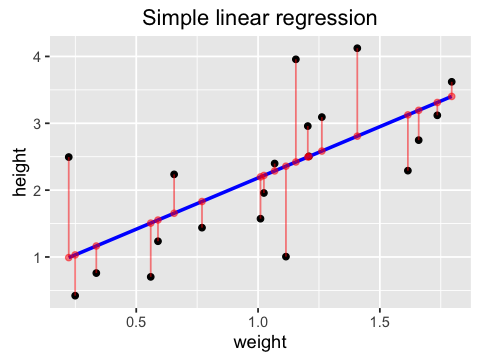

In [3]:
lm.fit <- lm(data=df, height ~ weight)
df <- df %>%
    add_predictions(lm.fit) %>%
    add_residuals(lm.fit)

df %>% 
  ggplot(aes(x=weight, y=height)) + 
  geom_point() +
  geom_smooth(method="lm", se=F, alpha=0.7, color="blue") +
  geom_point(aes(y=pred), color="red", alpha=0.5) + 
  geom_linerange(aes(x=x, ymin=pred, ymax=y), color="red", alpha=0.5) + 
  labs(title="Simple linear regression")

### PCA line vs regression line

The PCA-line minimizes the (Euclidean) distance from the data points to the line. This can result in a steeper line, as you can see below

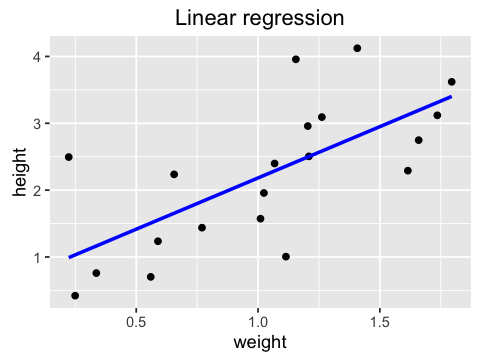

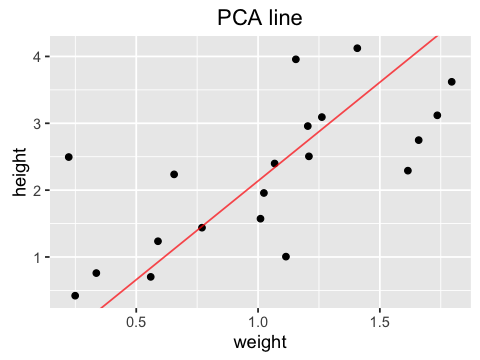

In [4]:
df %>% 
  ggplot(aes(x=weight, y=height)) + 
  geom_point() +
  geom_smooth(method="lm", se=F, alpha=0.7, color="blue") +
  labs(title="Linear regression")


# compute PCA line
pca.fit <- prcomp(df %>% select(weight, height))

pca.slope = pca.fit$rotation[2, 1] / pca.fit$rotation[1, 1]
pca.intercept = pca.fit$center[2] - pca.fit$center[1] * pca.slope

df %>% 
  ggplot(aes(x=weight, y=height)) + 
  geom_point() +
  geom_abline(slope=pca.slope, intercept=pca.intercept, alpha=0.7, color="red") +
  labs(title="PCA line")

Why do we prefer the linear regression line over the PCA-line (in supervised learning)?

- What if there is no relationship between X and Y
- What about prediction: predict Y given X (so we cannot change X)

What is benefit of PCA line?

- Symmetry; we cannot (or don't want to) distinguish an "important" variable Y.

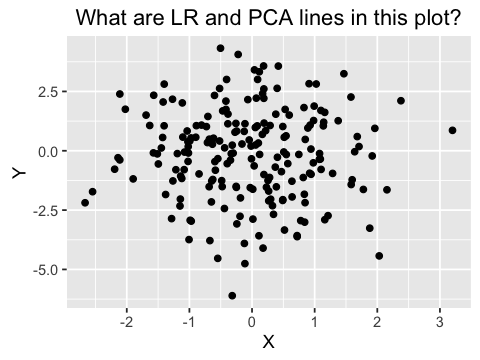

In [5]:
qplot(rnorm(200), 2*rnorm(200)) +
    labs(title="What are LR and PCA lines in this plot?", x="X", y="Y")

## Relation between linear regression and correlation coefficient

Work out algebra showing that we can write the slope of the regression line in terms of correlation coefficient (exercise: work out the algebra at home):

$$\hat{a} = \hat\rho \frac{s_y}{s_x} \text{ and } \hat{b} = \bar{Y} - \hat{a} \bar{X}$$

From here we can see that if we increase $x$ by one (sample) standard deviation, then our prediction of $y$ increases by $\hat{\rho}$ (sample) standard deviations.

Hence, compared to the SD line, the slope gets damped in terms of the (empirical) correlation coefficient.

In [6]:
summary(lm.fit)


Call:
lm(formula = height ~ weight, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3530 -0.4871 -0.2270  0.4739  1.5364 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.6489     0.4363   1.487 0.154230    
weight        1.5338     0.3843   3.991 0.000856 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8126 on 18 degrees of freedom
Multiple R-squared:  0.4695,	Adjusted R-squared:   0.44 
F-statistic: 15.93 on 1 and 18 DF,  p-value: 0.0008563


#### Compare output with correlations:

In [7]:
# slope in terms of correlation coefficient
cat("Coefficient for weight based on correlation:", cor(df$height, df$weight) * sqrt(var(df$height) / var(df$weight)))

Coefficient for weight based on correlation: 1.533795

In [8]:
# r-squared in terms of correlation
cat("R-squared in terms of correlation:", cor(df$height, df$weight)^2)

R-squared in terms of correlation: 0.4695022

## R squared

$R^2$ gives the squared correlation coefficient between the fitted values, or predictions, and the outcome.
Hence, if the $R^2$ value is high, the fitted values "explain most of the variance".

**Exercise**: show that in simple linear regression, $R^2 = \hat\rho^2$.

### $R^2$ and having an $R^2 = 1$: 

Let's look at an example in 2 dimensions. 
Note that $R^2 = 1$ is always true when $p \ge n$:
Note that 2 points in 3 dimensions give infinite number of solutions as we can rotate the plane through two points.

Downsides of $R^2$:

- Always increases if we add more covariates
- Model / noise dependent (what is the optimal $R^2$; do we always want to maximize $R^2$?)

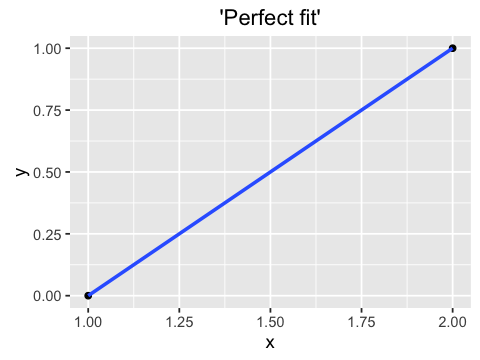

In [9]:
tibble(x = c(1, 2), y = c(0, 1)) %>%
    ggplot(aes(x=x, y=y)) +
    geom_point() + 
    geom_smooth(method="lm", se=F) +
    labs(title="'Perfect fit'")

## Residuals

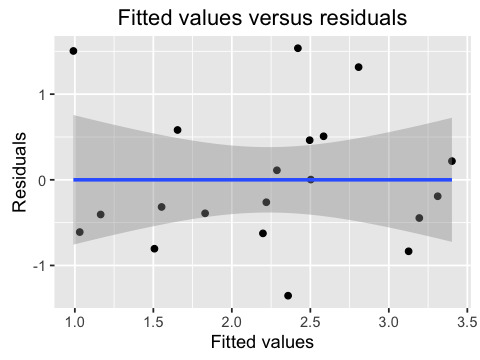

In [10]:
df %>% ggplot(aes(x=pred, y=resid)) +
    geom_point() +
    geom_smooth(method="lm") +
    labs(title="Fitted values versus residuals",
        x="Fitted values",
        y="Residuals")

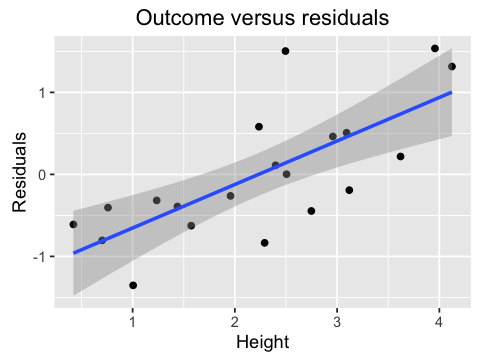

In [11]:
df %>% ggplot(aes(x=height, y=resid)) +
    geom_point() +
    geom_smooth(method="lm") + 
    labs(title="Outcome versus residuals",
        x="Height",
        y="Residuals")

In [12]:
lm(resid~height, data=df)


Call:
lm(formula = resid ~ height, data = df)

Coefficients:
(Intercept)       height  
    -1.1840       0.5305  


## Binary covariate

Here, we'll show that with a binary covariate, the model is equal to computing means of the different groups.

gender,male,male,male,male,male,male,male,male,female,female,female,female,female,female,female
weight,3.082595,4.995658,3.110512,5.325977,4.340951,5.262076,6.189657,5.866736,3.735091,2.213696,2.123026,1.779132,4.616652,3.498044,4.602559


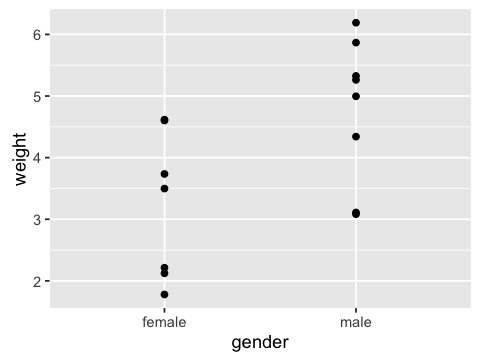

In [13]:
n.male <- 8
n.female <- 7

gender <- append(rep("male", n.male), rep("female", n.female))
weight <- append(rnorm(n.male) + 4, rnorm(n.female) + 3)

df.gender <- tibble(gender=gender, weight=weight)

df.gender %>% 
    ggplot(aes(x=gender, y=weight)) +
    geom_point()

t(df.gender)

In [14]:
# compute average weight
df.gender %>%
    summarise(avg.weight=mean(weight))

avg.weight
4.049491


In [15]:
# compute average weight using group_by
df.gender %>%
    group_by(gender) %>%
    summarise(avg.weight=mean(weight))

gender,avg.weight
female,3.224028
male,4.771770


### Intercept only model

$$ \hat{w} = \beta_0 $$

In [16]:
lm.simple <- lm(weight ~ 1, df.gender)
lm.simple


Call:
lm(formula = weight ~ 1, data = df.gender)

Coefficients:
(Intercept)  
      4.049  


### Gender model with intercept:

$$ \hat{w} = \beta_0 + \beta_1 \mathbb{1}_{\text{male}}$$

How to interpret $\beta_0$ and $\beta_1$?

In [17]:
lm.intercept <- lm(weight ~ gender, df.gender)
lm.intercept


Call:
lm(formula = weight ~ gender, data = df.gender)

Coefficients:
(Intercept)   gendermale  
      3.224        1.548  


### Gender model without intercept:

$$ \hat{w} =  \beta_0 \mathbb{1}_{\text{female}} +  \beta_1 \mathbb{1}_{\text{male}} $$

How to interpret $\beta_0$ and $\beta_1$?

In [18]:
lm.no_intercept <- lm(weight ~ 0 + gender, df.gender)
lm.no_intercept


Call:
lm(formula = weight ~ 0 + gender, data = df.gender)

Coefficients:
genderfemale    gendermale  
       3.224         4.772  


### Discussion


**Including variables**: Should we always include covariates? 
Can you think of a scenario where this might not be a good idea? Why not?

Good: We are able to get more granularity, and pick up differences between groups.

Bad: We are splitting data, which leads to loss of precision. 
What if there is no difference in weight between male and female gender?

**Advanced**: Is there a middle ground? 
Think how ridge regression might help.
Powerful methods exist that are very good at this: hierarchical / mixed effects models, 
but those are beyond the scope of this course.

**How many models**: How many distinct means are there if we have 1 binary feature?

How many different means with $p$ binary features? (Think about $p=2$ first)

## Correlated variables

Consider a model where $Y_i = X_i + Z_i + \epsilon_i$, for $i=1,\ldots,n$

Suppose we fit the linear model `lm(y ~ x)` (for example, because we might not have data on $Z$). 
What is the resulting coefficient you expect?

Maybe surprisingly, the answer is, one cannot say what coefficient to expect without knowing more 
about the joint distribution between $X$ and $Z$. 
Excluding a variable that belongs in the model can therefore lead to spurious outcomes. 
This is known as **missing variable bias**, the fitted coefficient also has to explain the missing variable as well as possible. 
As discussed in Problem Set 2, this might not be a problem for prediction, but it definitely is for inference!


In [19]:
library(MASS, pos = "package:base")

# create functions
create_data <- function(rho, n) {
    # creates a dataframe with X, Z with correlation coefficient rho
    # and Y = X + Z + rnorm
    sigma <- 1
    Sigma <- matrix(c(1, rho, rho, 1), 2)
    mu <- c(0, 0)
    X <- mvrnorm(n, mu=mu, Sigma=Sigma)
    df.xyz <-  as_data_frame(X)
    colnames(df.xyz) <- c("x", "z") 
    df.xyz["y"] = df.xyz$x + df.xyz$z + rnorm(n)
    return(df.xyz)
}

extract_coefs <- function(df) {
    # extracts regression coefficients for beta corresponding to X and Z
    # if we first regress Y on X, and then regress the residuals on Z
    lm.x <- lm(y ~ 0+x, df)
    df<- df %>% 
        add_residuals(lm.x)
    lm.z <- lm(resid ~ 0+z, df)
    return(c(coefficients(lm.x)[1], coefficients(lm.z)[1]))
}


Attaching package: ‘MASS’

The following object is masked _by_ ‘package:dplyr’:

    select



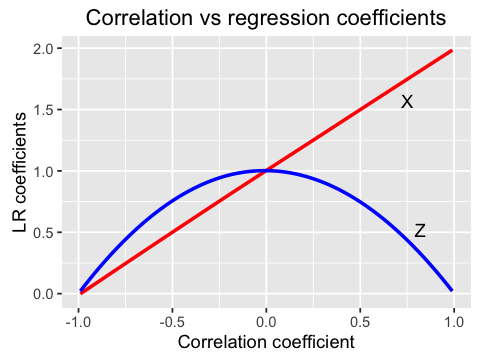

In [20]:
# run the simulation
n <- 2000
rhos <- seq(-0.99, 0.99, 0.01)
out <- rhos %>% lapply(function(rho) { create_data(rho, n) %>% extract_coefs() })
# dirty munging...
out.df <- as_data_frame(t(matrix(unlist(out), 2)))
colnames(out.df) <- c("coef.X", "coef.Z")
out.df$rhos <- rhos


v = seq(-1, 1, 0.1)
# plot outcomes
out.df %>% ggplot(aes(x=rhos)) +
    geom_smooth(aes(y=coef.X), color="red") +
    geom_smooth(aes(y=coef.Z), color="blue") +
    labs(x="Correlation coefficient", y="LR coefficients",
        title="Correlation vs regression coefficients") +
    annotate("text", x=0.75, y=1.57, label = "X") + 
    annotate("text", x=0.82, y=0.52, label="Z")

NB: That the coefficients are positive, and in particular 0 when the correlation coefficient is negative one is an artifact of the model $Y = X + Z + \epsilon$. We can easily change this by using a different model for $Y$.

Furthermore, notice that when correlation coefficient is close to -1, it really does look like there is no relationship between X and Y when we plot these. Similarly, when the correlation coefficient is close to 1, the linear model with slope of 2 really does fit the data.

As last remark, it's interesting that a correlation coefficient close to 1 (or -1), is great for prediction when we only have access to X; because we automatically also take the effects of Z into account. When we talk about inference though, this is terrible! We would much prefer the situation where the correlation coefficient is 0, such
that we get an unbiased estimate of the coefficient for X.